```{contents}
```
## **Conditional Node in LangGraph**

A **Conditional Node** in LangGraph is a **control node** that dynamically selects the next execution path based on the **current state**.
It enables **branching, loops, decision-making, and adaptive workflows**, making LangGraph suitable for intelligent, autonomous systems.

---

### **1. Intuition**

Traditional pipelines are linear.
Real-world reasoning is **non-linear**:

* "If the answer is uncertain → research more"
* "If confidence is high → finalize"
* "If error → retry"

A Conditional Node encodes these decisions.

> **State → Condition → Branch Selection → Next Node**

---

### **2. Formal Definition**

A Conditional Node consists of:

| Component          | Role                              |
| ------------------ | --------------------------------- |
| Condition Function | Evaluates state                   |
| Routing Table      | Maps condition output → next node |
| Edges              | Execution transitions             |

---

### **3. Conceptual Structure**

```
            ┌──────────┐
            │  Node A  │
            └────┬─────┘
                 ↓
          ┌────────────────┐
          │ Conditional    │
          │   Router       │
          └────┬─────┬─────┘
               ↓     ↓
          Node B   Node C
```

---

### **4. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    confidence: float
    answer: str

def evaluate(state: State):
    return "final" if state["confidence"] > 0.8 else "revise"

builder = StateGraph(State)

builder.add_node("router", lambda s: s)
builder.add_node("final", lambda s: {"answer": s["answer"]})
builder.add_node("revise", lambda s: {"confidence": s["confidence"] + 0.2})

builder.set_entry_point("router")

builder.add_conditional_edges(
    "router",
    evaluate,
    {
        "final": "final",
        "revise": "revise"
    }
)

builder.add_edge("revise", "router")
builder.add_edge("final", END)

graph = builder.compile()
```

---

### **5. Execution Behavior**

```
router → revise → router → revise → router → final → END
```

This is both **branching** and **cyclic**.

---

### **6. Common Variants**

| Variant          | Purpose           |
| ---------------- | ----------------- |
| Binary Decision  | Yes/No logic      |
| Multi-way Router | Multiple branches |
| Loop Controller  | Continue/stop     |
| Retry Controller | Error recovery    |
| Planner Router   | Task allocation   |
| Agent Selector   | Choose agent      |
| Model Router     | Select LLM        |
| Tool Router      | Select tool       |

---

### **7. Production Use Cases**

| Use Case           | Benefit            |
| ------------------ | ------------------ |
| ReAct agents       | Reasoning + acting |
| Reflection loops   | Self-improvement   |
| Error recovery     | Resilience         |
| Cost control       | Model routing      |
| Human oversight    | Approval gating    |
| Autonomous systems | Adaptive behavior  |

---

### **8. Safety & Design Guidelines**

* Always include a **termination path**
* Limit recursion with `recursion_limit`
* Log routing decisions
* Use deterministic conditions where possible
* Include fallback branches

---

### **9. Mental Model**

A Conditional Node is the **brain** of the graph:

> **It decides what happens next.**

Without conditional nodes, LangGraph is a pipeline.
With them, it becomes an **intelligent control system**.

### Demonstration

In [1]:
from typing import TypedDict

class State(TypedDict):
    answer: str
    confidence: float

def draft(state: State):
    return {"answer": "Initial draft", "confidence": 0.4}

def revise(state: State):
    improved = state["answer"] + " + improvement"
    new_confidence = min(1.0, state["confidence"] + 0.25)
    return {"answer": improved, "confidence": new_confidence}

def evaluate(state: State):
    return "final" if state["confidence"] >= 0.8 else "revise"

def finalize(state: State):
    return {"answer": f"Final answer: {state['answer']}"}




In [2]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("draft", draft)
builder.add_node("revise", revise)
builder.add_node("final", finalize)

builder.set_entry_point("draft")

builder.add_conditional_edges(
    "draft",
    evaluate,
    {
        "revise": "revise",
        "final": "final"
    }
)

builder.add_conditional_edges(
    "revise",
    evaluate,
    {
        "revise": "revise",
        "final": "final"
    }
)

builder.add_edge("final", END)

graph = builder.compile()


In [3]:
result = graph.invoke({"answer": "", "confidence": 0.0})
print(result)


{'answer': 'Final answer: Initial draft + improvement + improvement', 'confidence': 0.9}


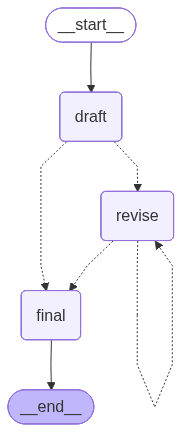

In [5]:
from IPython.display import Image, display
Image(graph.get_graph().draw_mermaid_png())
